# Generative AI for Ophthalmological Image Synthesis

## Project Overview

This project aims to develop a generative AI model for creating synthetic ophthalmological images based on the Brazilian Multilabel Ophthalmological Dataset (BRSET). My goal is to generate high quality, diverse images that could potentially be used for augmenting datasets, improving model training, and advancing research in ophthalmology.

## Methodology

My approach is inspired by the paper "Using generative AI to investigate medical imagery models and datasets" (Lang et al., 2024). I will implement a multistep process:

1. **Image Classification**: Train a deep learning classifier on the BRSET dataset to predict various ophthalmological conditions.

2. **Generative Model**: Develop a StyleGAN2-based generative model, incorporating guidance from my trained classifier.

3. **Attribute Discovery**: Use the trained generator to identify and visualize key attributes that influence the classifier's predictions.

4. **Analysis and Interpretation**: Examine the generated images and attributes to gain insights into the model's understanding of ophthalmological features.

## Project Goals

- Create a high-performance classifier for ophthalmological conditions using the BRSET dataset.
- Implement a StyleGAN2 based generator capable of producing realistic eye images.
- Discover and visualize attributes that are important for classifying various eye conditions.
- Generate synthetic images that could potentially be used to augment existing datasets.

## Ethical Considerations

While this project aims to advance medical imaging research, we must be mindful of the ethical implications of generating synthetic medical data. All generated images should be clearly labeled as synthetic and not used for diagnostic purposes without extensive validation.

## Getting Started

This notebook will guide you through the implementation of each step in my methodology. Let's begin by setting up our environment and loading the BRSET dataset.

In [148]:
# Standard libraries
import os
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

# Deep learning and image processing
import tensorflow as tf
from tensorflow import keras
import cv2
from PIL import Image

# TensorFlow and Keras modules
from tensorflow.keras import layers, models, optimizers, losses, metrics, backend, applications
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.mixed_precision import global_policy

# Scikit-learn for data splitting and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Stats libraries for statistical analysis
from scipy.stats import pearsonr

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure TensorFlow is using GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Enable eager execution
tf.compat.v1.enable_eager_execution()

# Display all outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Print environment information
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("Eager execution enabled:", tf.executing_eagerly())

Num GPUs Available: 0
TensorFlow version: 2.16.1
Keras version: 3.3.3
Eager execution enabled: True


### Load in the labels dataset

In [149]:
# Import the data labels 
labels = pd.read_csv('/Volumes/Extreme SSD/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/labels.csv')

# Display the first few rows of the data labels
labels.head()

image_id  patient_id    camera  patient_age comorbidities diabetes_time_y  \
0  img00001           1  Canon CR         48.0     diabetes1              12   
1  img00002           1  Canon CR         48.0     diabetes1              12   
2  img00003           2  Canon CR         18.0     diabetes1               7   
3  img00004           2  Canon CR         18.0     diabetes1               7   
4  img00005           3  Canon CR         22.0     diabetes1              11   

  insuline  patient_sex  exam_eye diabetes  ... amd vascular_occlusion  \
0      yes            1         1      yes  ...   0                  0   
1      yes            1         2      yes  ...   0                  0   
2      yes            2         1      yes  ...   0                  0   
3      yes            2         2      yes  ...   0                  0   
4      yes            1         1      yes  ...   0                  0   

   hypertensive_retinopathy  drusens  hemorrhage  retinal_detachment  \
0                         0        0           0                   0   
1                         0        0           0                   0   
2                         0        0           0                   0   
3                         0        0           0                   0   
4                         0        0           0                   0   

   myopic_fundus  increased_cup_disc  other   quality  
0              0                   1      0  Adequate  
1              0                   1      0  Adequate  
2              0                   0      0  Adequate  
3              0                   0      0  Adequate  
4              0                   0      0  Adequate  

[5 rows x 34 columns]

### Load in images and inspect the data

Batch of images shape: (100, 224, 224, 3)


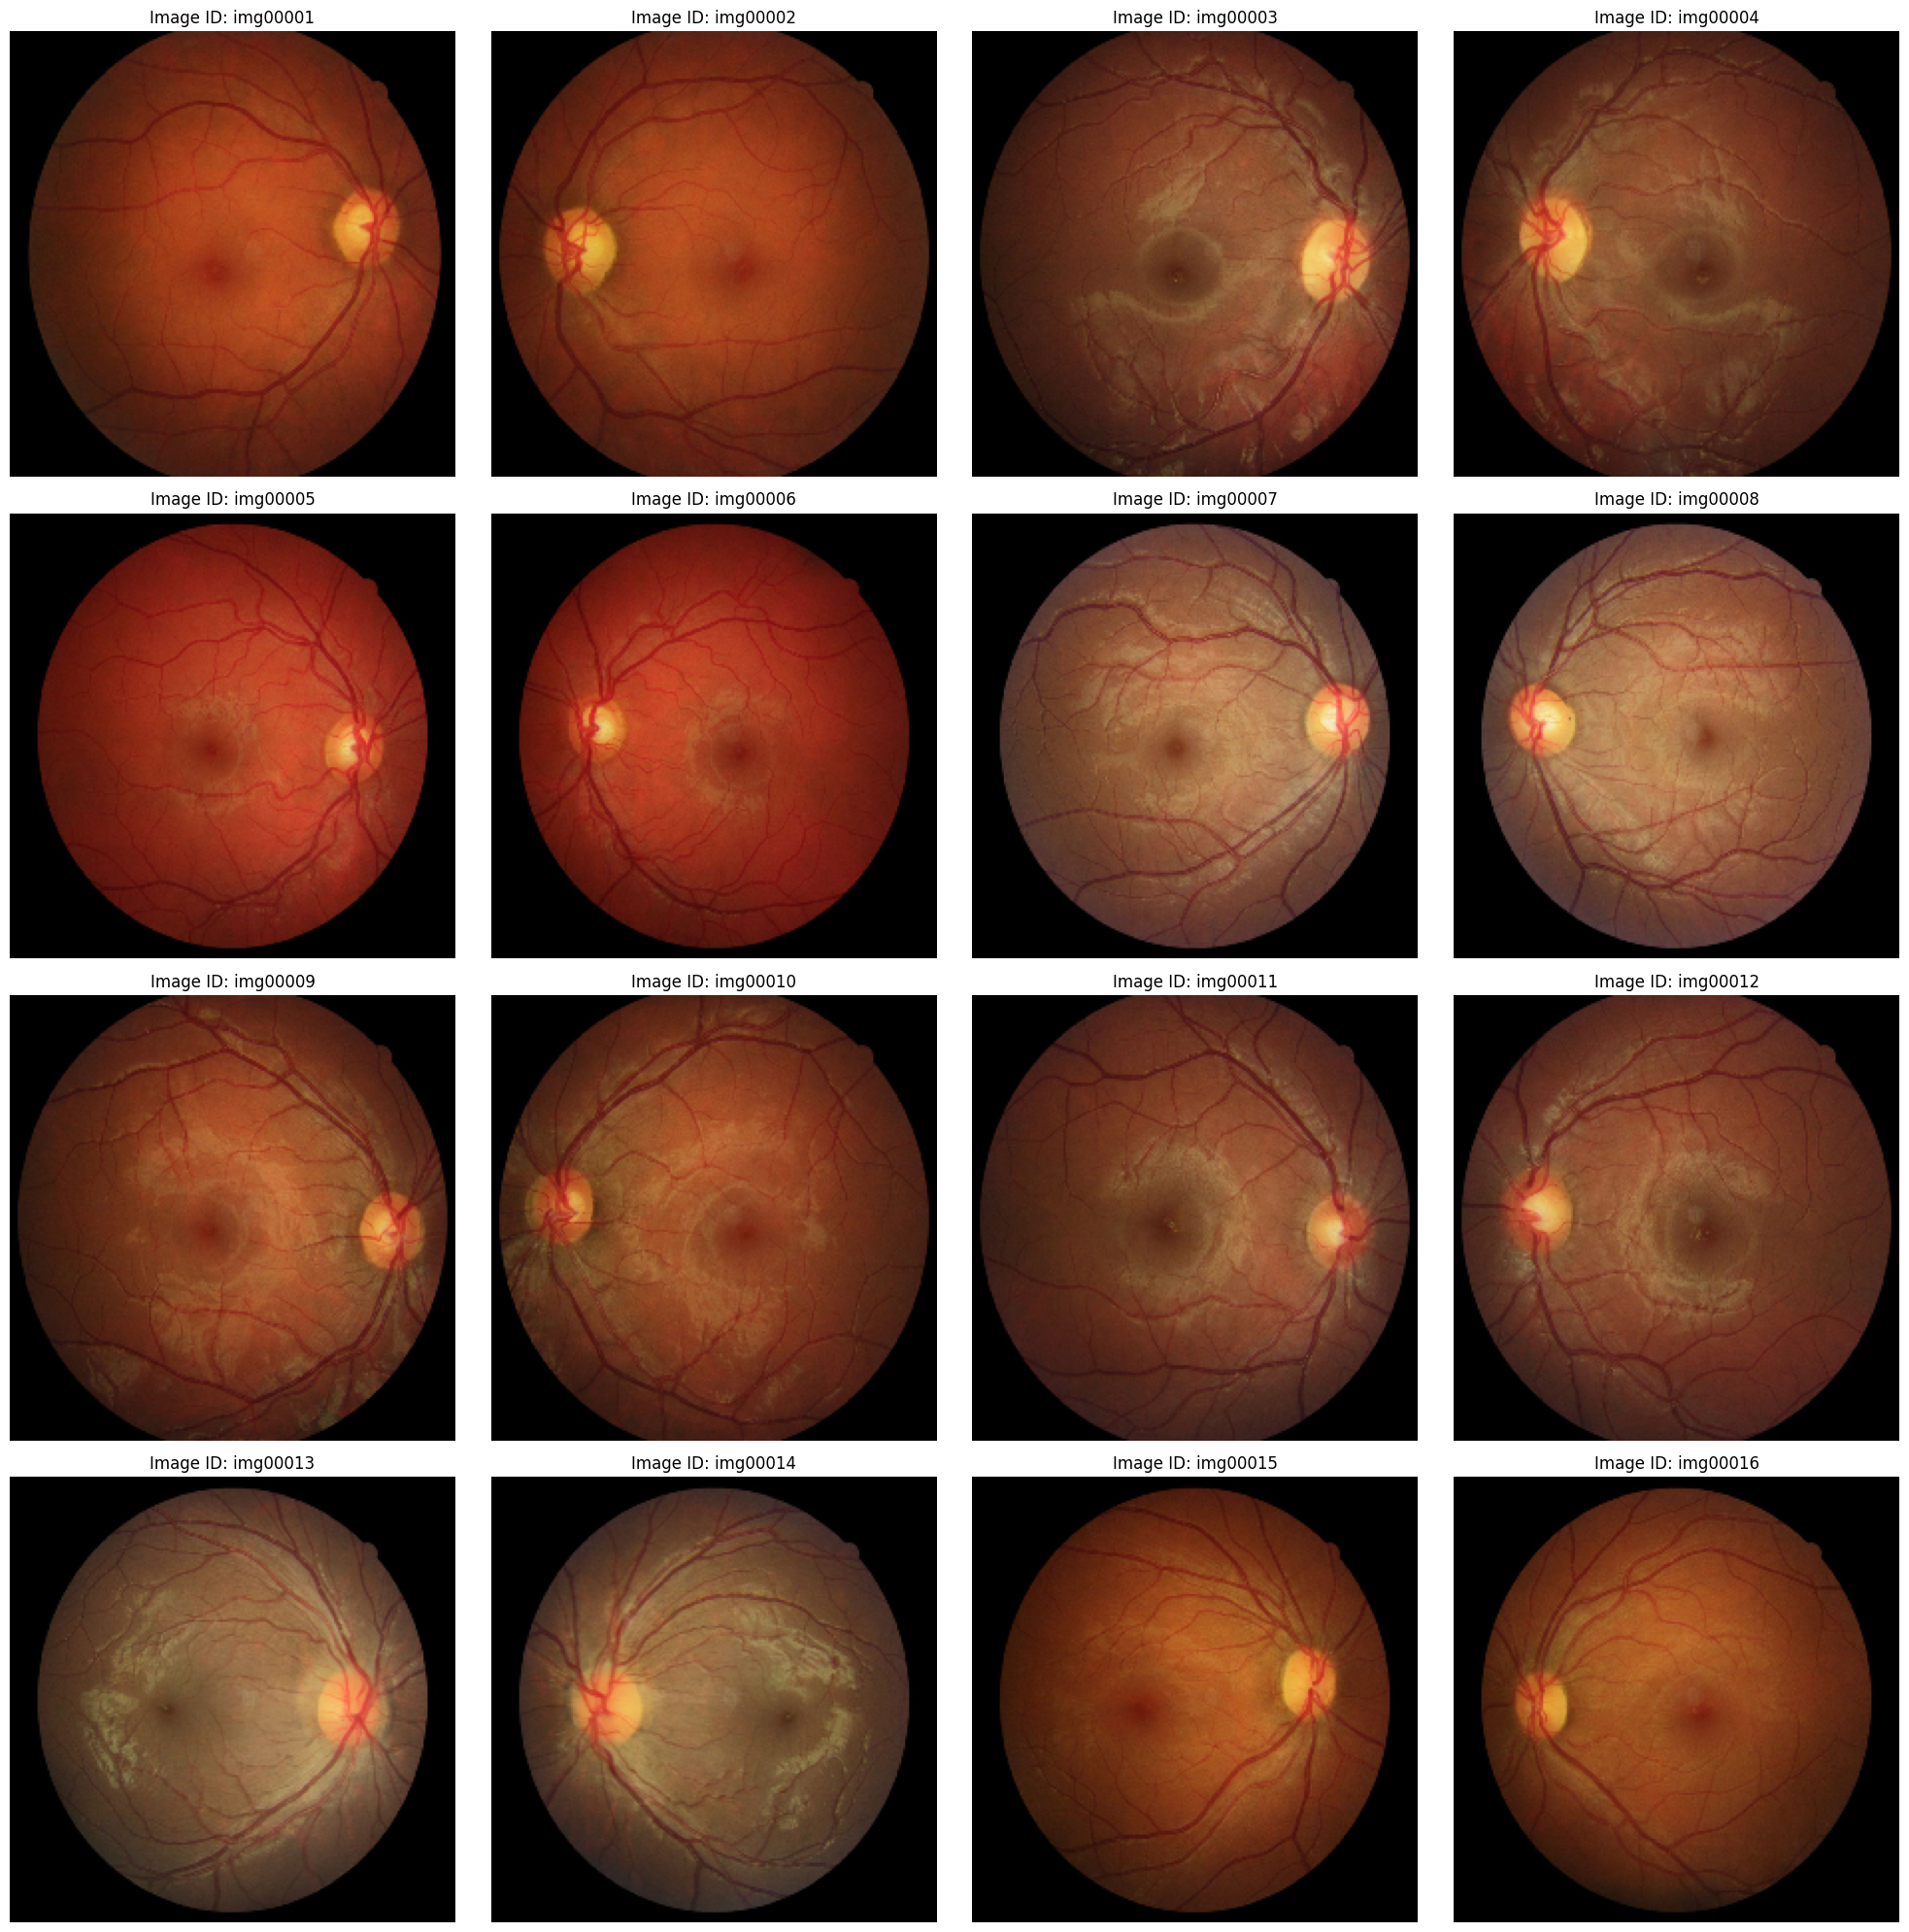

In [150]:
# Define the path to the fundus photos
IMAGE_PATH = '/Volumes/Extreme SSD/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos/'

def load_and_preprocess_image(image_id, target_size=(224, 224)):
    """
    Load and preprocess a fundus photo given its image_id.
    
    Args:
    image_id (str): The ID of the image to load.
    target_size (tuple): The target size to resize the image to.
    
    Returns:
    numpy.array: The preprocessed image as a numpy array.
    """
    # Construct the full path to the image
    image_path = os.path.join(IMAGE_PATH, f"{image_id}.jpg")
    
    # Load the image
    img = load_img(image_path, target_size=target_size)
    
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Normalize the image
    img_array = img_array / 255.0
    
    return img_array

def load_batch_of_images(image_ids, batch_size=32):
    """
    Load and preprocess a batch of fundus photos.
    
    Args:
    image_ids (list): List of image IDs to load.
    batch_size (int): Number of images to load at once.
    
    Returns:
    numpy.array: A batch of preprocessed images.
    """
    images = []
    for i in range(0, len(image_ids), batch_size):
        batch_ids = image_ids[i:i+batch_size]
        batch_images = [load_and_preprocess_image(id) for id in batch_ids]
        images.extend(batch_images)
    return np.array(images)

# Load the first 100 images 
first_100_image_ids = labels['image_id'].iloc[:100].tolist()
batch_of_images = load_batch_of_images(first_100_image_ids)

print(f"Batch of images shape: {batch_of_images.shape}")

# Display a grid of the first 16 images
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i+1);
    plt.imshow(batch_of_images[i]);
    plt.axis('off');
    plt.title(f"Image ID: {first_100_image_ids[i]}");
plt.tight_layout();
plt.show();

## EDA and dataset preparation/cleaning

### Labels data EDA

In [151]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16266 entries, 0 to 16265
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_id                  16266 non-null  object 
 1   patient_id                16266 non-null  int64  
 2   camera                    16266 non-null  object 
 3   patient_age               10821 non-null  float64
 4   comorbidities             8030 non-null   object 
 5   diabetes_time_y           1910 non-null   object 
 6   insuline                  1714 non-null   object 
 7   patient_sex               16266 non-null  int64  
 8   exam_eye                  16266 non-null  int64  
 9   diabetes                  16266 non-null  object 
 10  nationality               16266 non-null  object 
 11  optic_disc                16266 non-null  object 
 12  vessels                   16266 non-null  int64  
 13  macula                    16266 non-null  int64  
 14  DR_SDR

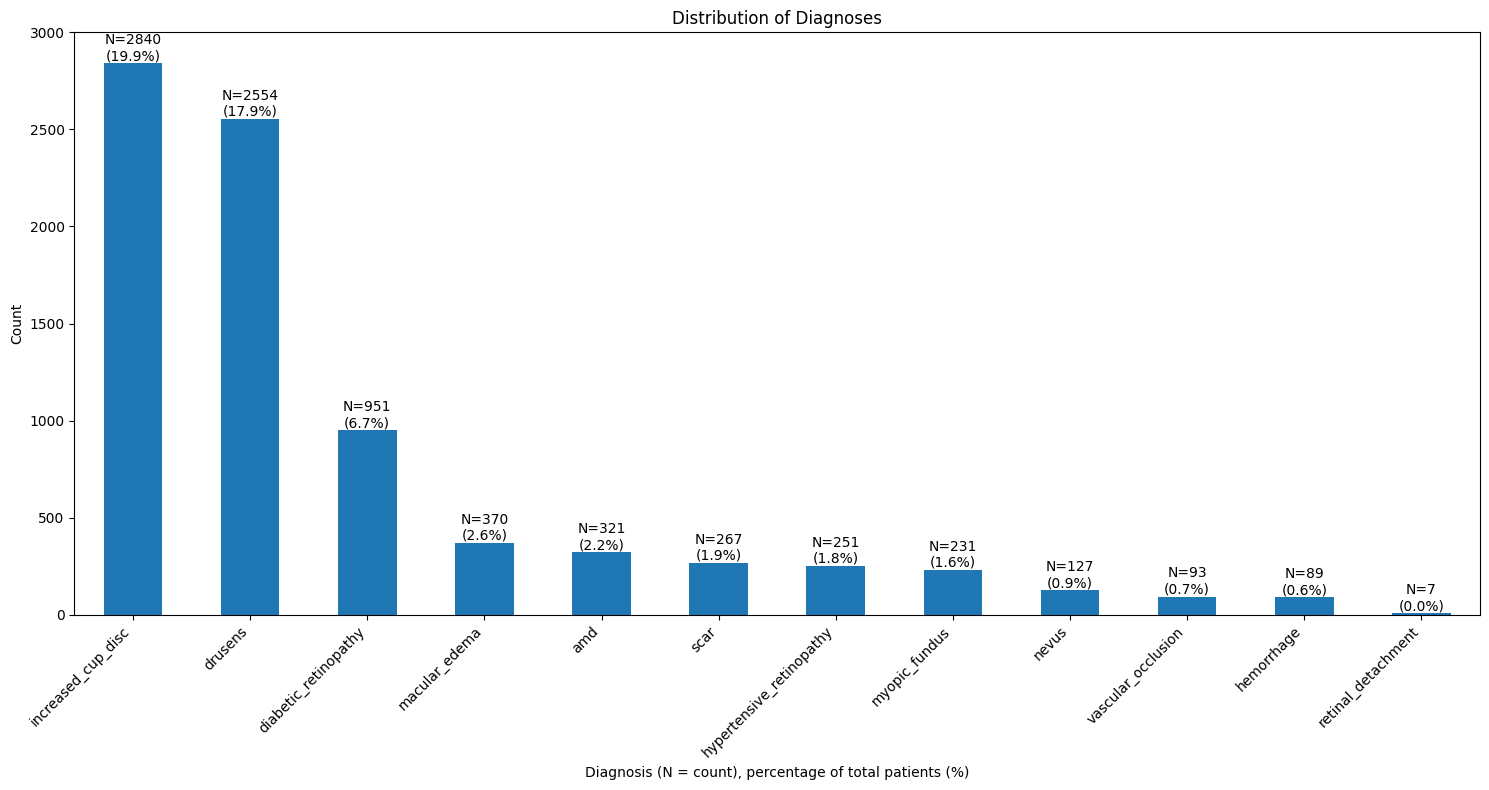

In [185]:
# List of binary diagnosis columns
binary_diagnoses = ['diabetic_retinopathy', 'macular_edema', 'scar', 'nevus', 'amd',
                    'vascular_occlusion', 'hypertensive_retinopathy', 'drusens',
                    'hemorrhage', 'retinal_detachment', 'myopic_fundus', 'increased_cup_disc']

# Calculate the counts and percentages in total patient population
diagnosis_counts = labels[binary_diagnoses].sum().sort_values(ascending=False)
total_patients = len(labels)
diagnosis_percentages = (diagnosis_counts / total_patients) * 100

plt.figure(figsize=(15, 8))
ax = diagnosis_counts.plot(kind='bar')

# Add count and percentage labels on top of each bar
for i, (count, percentage) in enumerate(zip(diagnosis_counts, diagnosis_percentages)):
    ax.text(i, count, f'N={count}\n({percentage:.1f}%)', 
            ha='center', va='bottom')

plt.title('Distribution of Diagnoses')
plt.xlabel('Diagnosis (N = count), percentage of total patients (%)')
plt.ylabel('Count')
plt.yticks(range(0, 3001, 500))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

The highest diagnosis frequency in the dataset is increased cup disc ratio (CDR), followed by drusens, and diabetic retinopathy. 

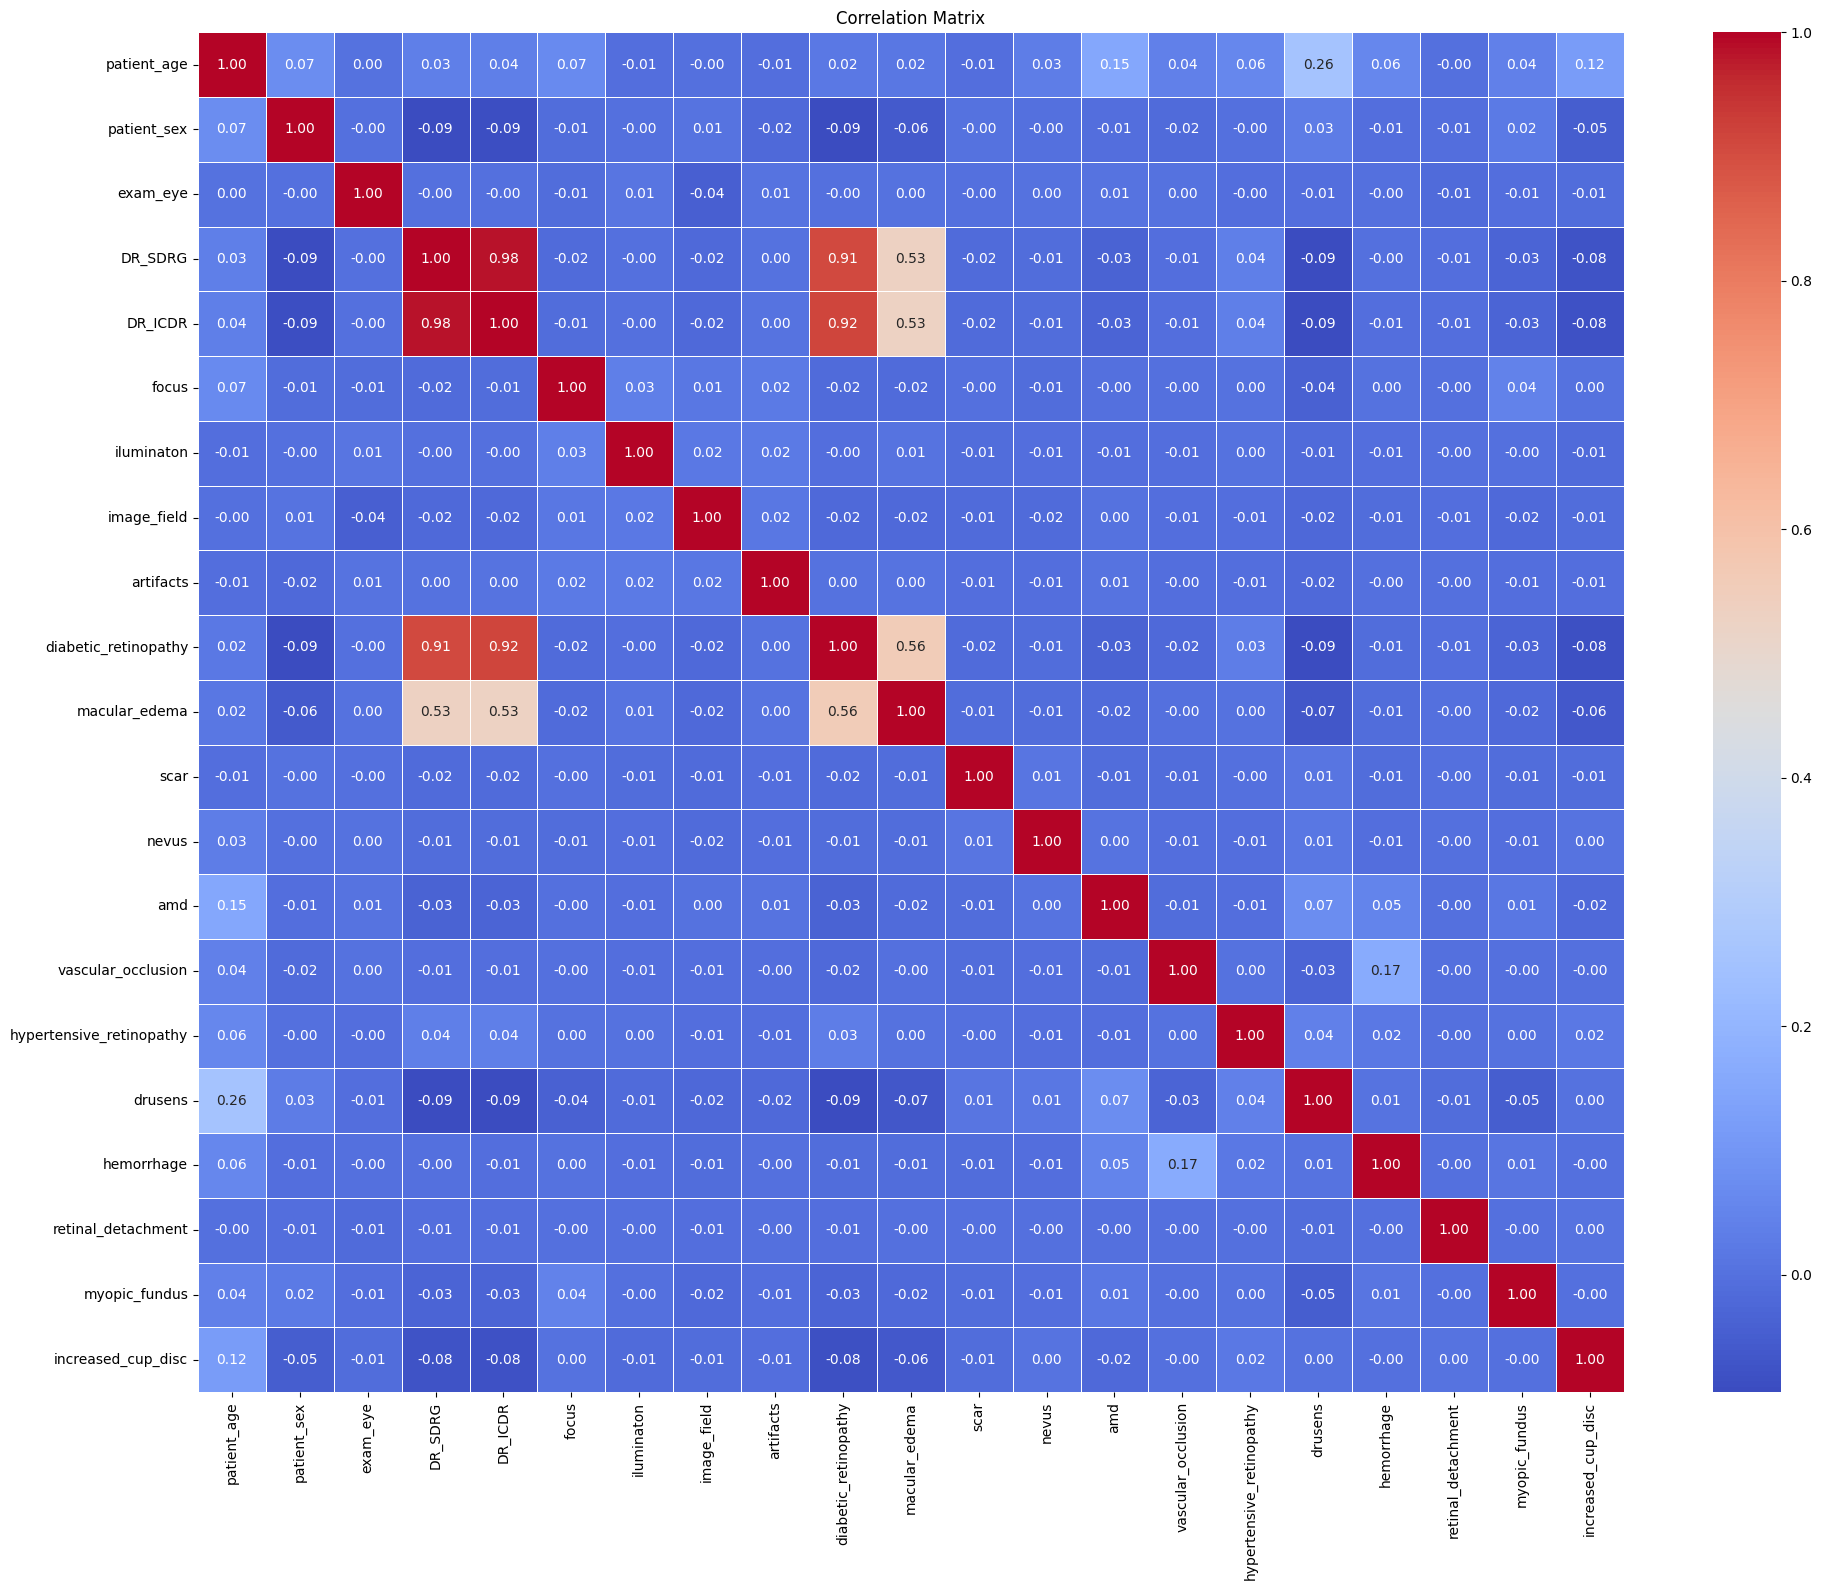

In [153]:
# Correlation matrix of numerical columns and binary diagnoses
numerical_columns = ['patient_age', 'patient_sex', 'exam_eye', 'DR_SDRG', 'DR_ICDR', 
                     'focus', 'iluminaton', 'image_field', 'artifacts']
correlation_matrix = labels[numerical_columns + binary_diagnoses].corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show();

In [154]:
# Print out top correlations in the correlation matrix
def print_top_correlations(correlation_matrix, n=20):
    # Unstack the correlation matrix
    correlations = correlation_matrix.unstack()

    # Sort correlations in descending order of absolute value
    correlations = correlations.abs().sort_values(ascending=False)

    # Remove self correlations
    correlations = correlations[correlations != 1.0]

    # Create a set to keep track of pairs 
    seen_pairs = set()

    print(f"Top {n} Correlation Pairs:")
    count = 0
    for (var1, var2), correlation in correlations.items():
        pair = frozenset([var1, var2])

        if pair not in seen_pairs:
            print(f"{var1} - {var2}: {correlation_matrix.loc[var1, var2]:.4f}")
            seen_pairs.add(pair)
            count += 1

            if count == n:
                break

correlation_matrix = labels[numerical_columns + binary_diagnoses].corr()
print_top_correlations(correlation_matrix, n=10)

Top 10 Correlation Pairs:
DR_SDRG - DR_ICDR: 0.9848
DR_ICDR - diabetic_retinopathy: 0.9173
diabetic_retinopathy - DR_SDRG: 0.9093
macular_edema - diabetic_retinopathy: 0.5572
macular_edema - DR_SDRG: 0.5328
macular_edema - DR_ICDR: 0.5269
drusens - patient_age: 0.2560
vascular_occlusion - hemorrhage: 0.1659
amd - patient_age: 0.1496
increased_cup_disc - patient_age: 0.1167


The correlation analysis of the Brazilian Retinal Image Dataset (BRSET) reveals several interesting relationships between various ophthalmological parameters and diagnoses.

1. **DR_SDRG - DR_ICDR (0.9853)**: 
   This extremely high correlation is expected as both are classification systems for diabetic retinopathy (DR). The Scottish Diabetic Retinopathy Grading Scheme (SDRG) and the International Clinical Diabetic Retinopathy (ICDR) scale are closely aligned in their assessment of DR severity.

2. **DR_ICDR - diabetic_retinopathy (0.9173)** and **diabetic_retinopathy - DR_SDRG (0.9103)**:
   These strong correlations indicate that both grading systems (ICDR and SDRG) are highly predictive of the presence of diabetic retinopathy. This validates the consistency between the binary classification (presence/absence) and the more detailed grading scales.

3. **diabetic_retinopathy - macular_edema (0.5611)**:
   This moderate positive correlation suggests that patients with diabetic retinopathy are more likely to also have macular edema. This is clinically significant as macular edema is a common complication of diabetic retinopathy.

4. **macular_edema - DR_SDRG (0.5406)** and **macular_edema - DR_ICDR (0.5337)**:
   These correlations further support the relationship between the severity of diabetic retinopathy (as measured by both scales) and the presence of macular edema. As the severity of DR increases, the likelihood of macular edema also increases.

5. **patient_age - drusens (0.2179)**:
   This weak positive correlation suggests that the presence of drusens (small yellow or white accumulations of extracellular material in the retina) is more common in older patients. This aligns with clinical knowledge, as drusens are often associated with age-related macular degeneration (AMD).

6. **vascular_occlusion - hemorrhage (0.1816)**:
   This weak positive correlation indicates a relationship between vascular occlusions and hemorrhages in the retina. This makes clinical sense, as occlusions can lead to bleeding in the affected blood vessels.

7. **patient_age - amd (0.1284)**:
   The weak positive correlation between age and age-related macular degeneration (AMD) is expected, as AMD is more prevalent in older populations.

8. **drusens - DR_SDRG (-0.0976)**:
   This very weak negative correlation might suggest a slight inverse relationship between the presence of drusens and the severity of diabetic retinopathy. However, given the low correlation coefficient, this relationship is likely not clinically significant and would require further investigation to determine if it's meaningful.

These correlations provide valuable insights into the relationships between various ophthalmological conditions and patient characteristics in the BRSET dataset. They highlight the interconnected nature of diabetic retinopathy, macular edema, and age-related eye conditions. These findings can inform feature selection for machine learning models and guide further clinical research into the progression and comorbidities of retinal diseases.

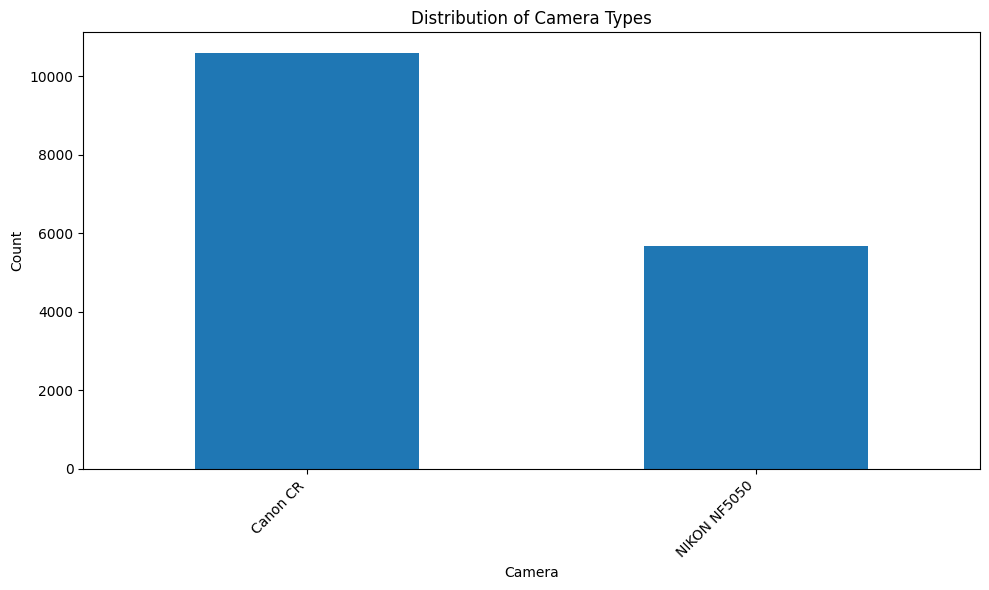

In [155]:
# Distribution of camera types
plt.figure(figsize=(10, 6))
labels['camera'].value_counts().plot(kind='bar')
plt.title('Distribution of Camera Types')
plt.xlabel('Camera')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

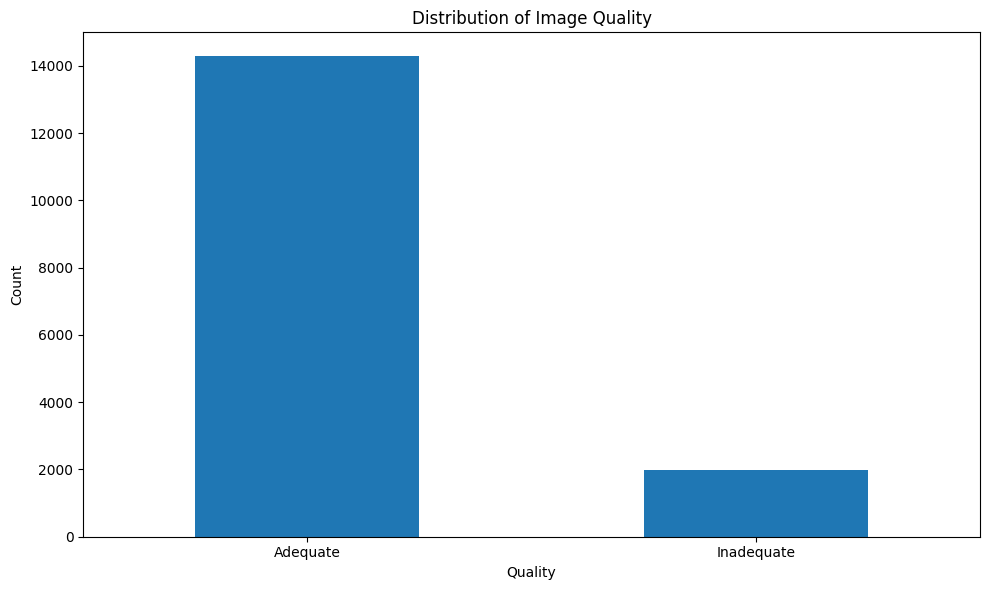

In [156]:
# Distribution of image quality
plt.figure(figsize=(10, 6))
labels['quality'].value_counts().plot(kind='bar')
plt.title('Distribution of Image Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show();

Based on the plot above we can see there is a subset of images labeled as inadequate. We will remove these images from the dataset as they are not useful for training our classifier.

In [157]:
# Shape before dropping inadequate images
labels.shape

(16266, 34)

In [158]:
# Drop the inadequate quality images
labels = labels[labels['quality'] != 'Inadequate']

In [159]:
# Shape after dropping inadequate quality images
labels.shape

(14279, 34)

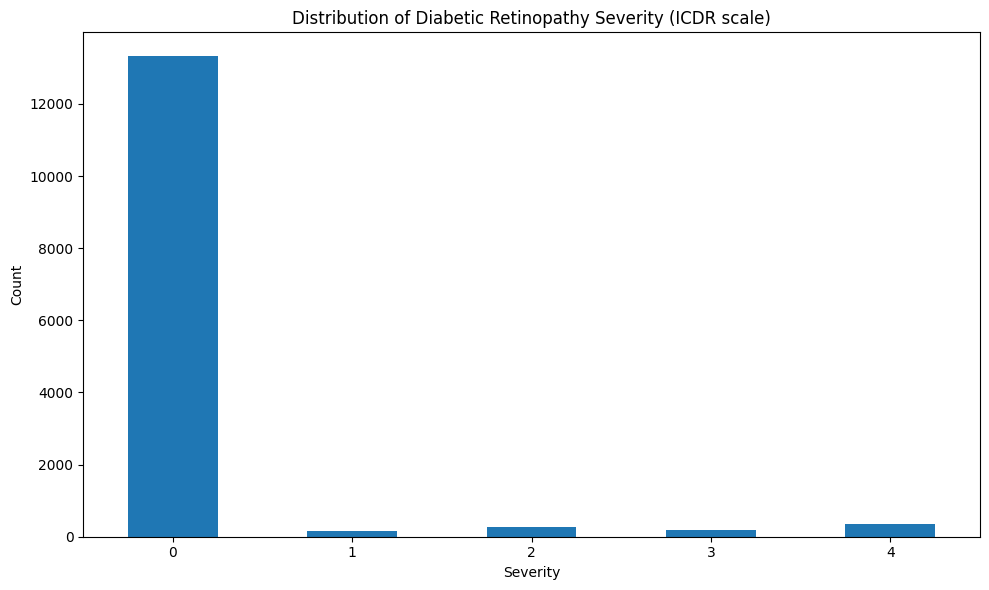

In [160]:
# Distribution of DR severity (DR_ICDR)
plt.figure(figsize=(10, 6))
labels['DR_ICDR'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Diabetic Retinopathy Severity (ICDR scale)')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show();

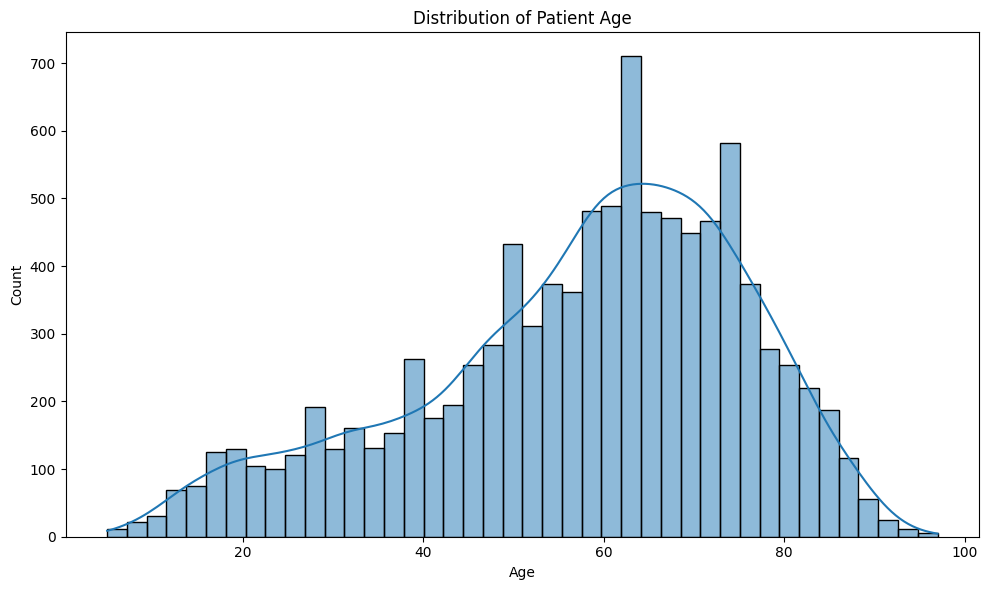

In [161]:
# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=labels, x='patient_age', kde=True)
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show();

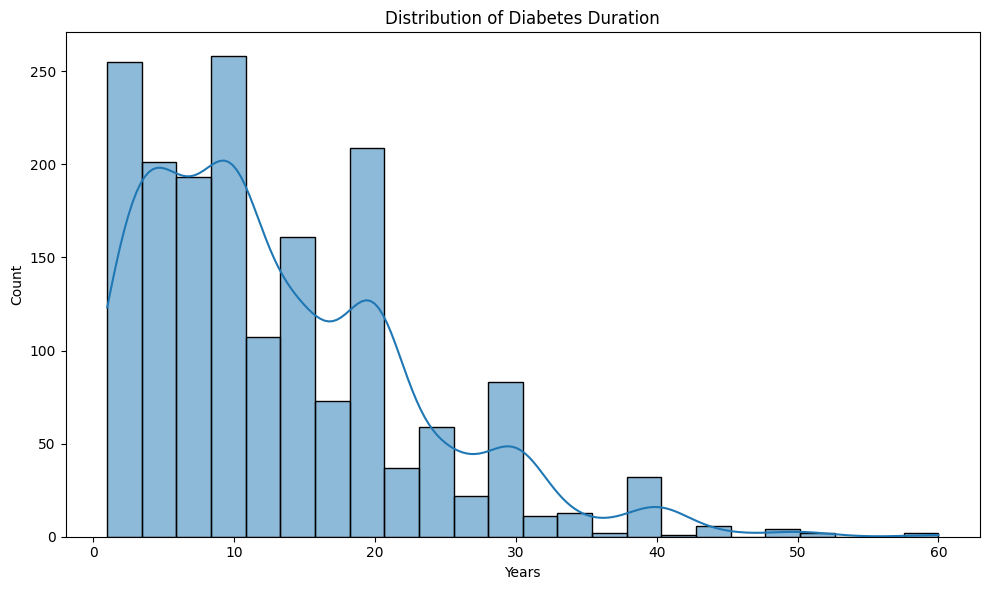

In [162]:
# Diabetes duration distribution
plt.figure(figsize=(10, 6))
labels['diabetes_time_y'] = pd.to_numeric(labels['diabetes_time_y'], errors='coerce')
sns.histplot(data=labels, x='diabetes_time_y', kde=True)
plt.title('Distribution of Diabetes Duration')
plt.xlabel('Years')
plt.ylabel('Count')
plt.tight_layout()
plt.show();

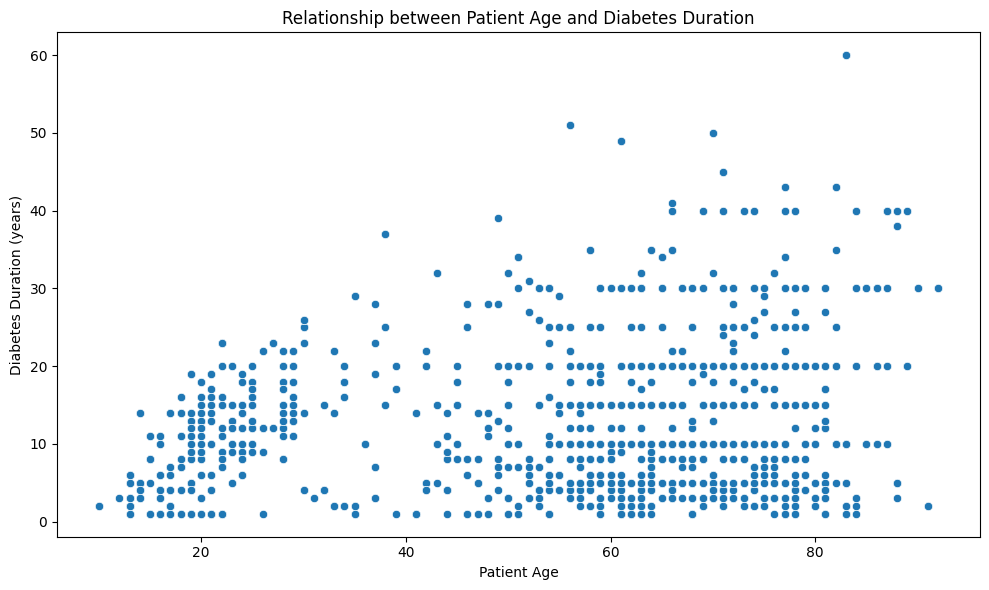

In [163]:
# Relationship between age and diabetes duration
plt.figure(figsize=(10, 6))
sns.scatterplot(data=labels, x='patient_age', y='diabetes_time_y')
plt.title('Relationship between Patient Age and Diabetes Duration')
plt.xlabel('Patient Age')
plt.ylabel('Diabetes Duration (years)')
plt.tight_layout()
plt.show();

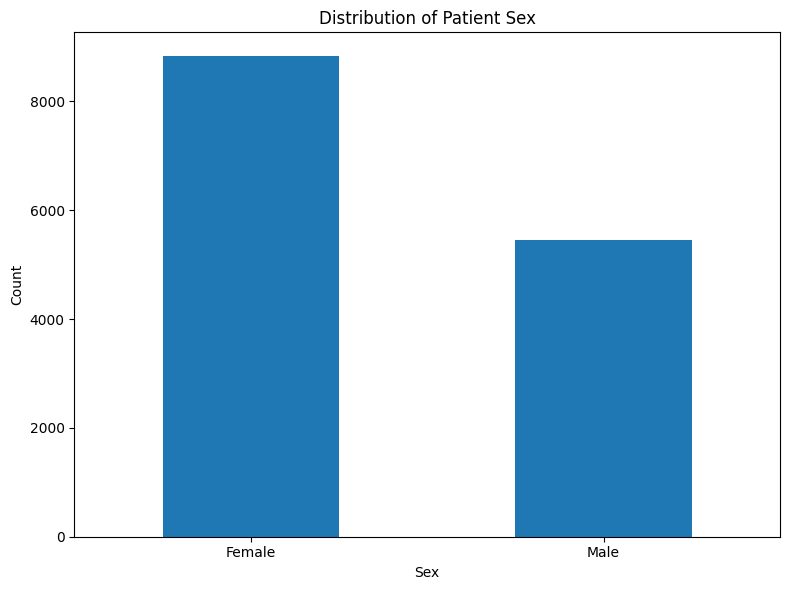

In [164]:
# Distribution of patient sex
plt.figure(figsize=(8, 6))
labels['patient_sex'].map({1: 'Male', 2: 'Female'}).value_counts().plot(kind='bar')
plt.title('Distribution of Patient Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show();

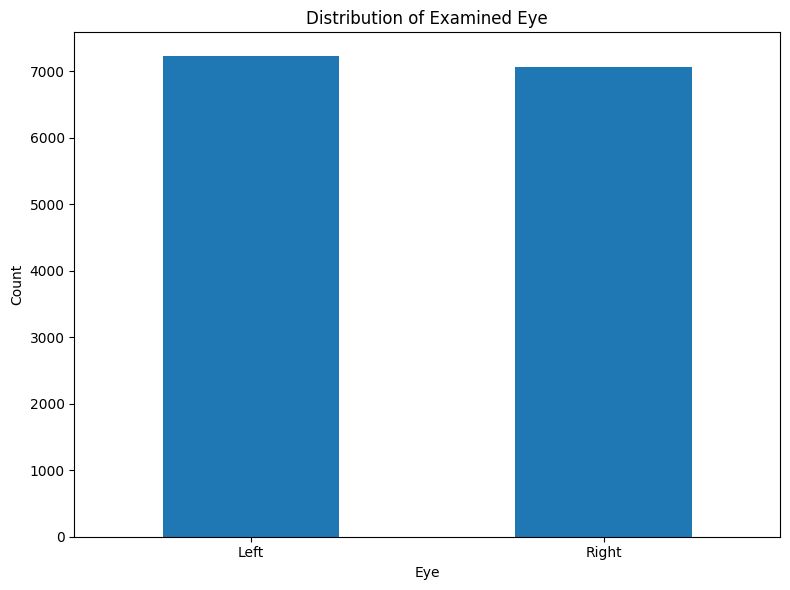

In [165]:
# Distribution of examined eye
plt.figure(figsize=(8, 6))
labels['exam_eye'].map({1: 'Right', 2: 'Left'}).value_counts().plot(kind='bar')
plt.title('Distribution of Examined Eye')
plt.xlabel('Eye')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show();

In [167]:
print("Summary Statistics:")
labels[numerical_columns + binary_diagnoses].describe()

Summary Statistics:


patient_age   patient_sex      exam_eye       DR_SDRG       DR_ICDR  \
count  9858.000000  14279.000000  14279.000000  14279.000000  14279.000000   
mean     57.460641      1.618111      1.505778      0.187968      0.187058   
std      18.207040      0.485867      0.499984      0.764434      0.753912   
min       5.000000      1.000000      1.000000      0.000000      0.000000   
25%      47.000000      1.000000      1.000000      0.000000      0.000000   
50%      60.000000      2.000000      2.000000      0.000000      0.000000   
75%      71.000000      2.000000      2.000000      0.000000      0.000000   
max      97.000000      2.000000      2.000000      4.000000      4.000000   

         focus  iluminaton  image_field  artifacts  diabetic_retinopathy  ...  \
count  14279.0     14279.0      14279.0    14279.0          14279.000000  ...   
mean       1.0         1.0          1.0        1.0              0.066601  ...   
std        0.0         0.0          0.0        0.0              0.249339  ...   
min        1.0         1.0          1.0        1.0              0.000000  ...   
25%        1.0         1.0          1.0        1.0              0.000000  ...   
50%        1.0         1.0          1.0        1.0              0.000000  ...   
75%        1.0         1.0          1.0        1.0              0.000000  ...   
max        1.0         1.0          1.0        1.0              1.000000  ...   

               scar         nevus           amd  vascular_occlusion  \
count  14279.000000  14279.000000  14279.000000        14279.000000   
mean       0.018699      0.008894      0.022481            0.006513   
std        0.135464      0.093892      0.148246            0.080443   
min        0.000000      0.000000      0.000000            0.000000   
25%        0.000000      0.000000      0.000000            0.000000   
50%        0.000000      0.000000      0.000000            0.000000   
75%        0.000000      0.000000      0.000000            0.000000   
max        1.000000      1.000000      1.000000            1.000000   

       hypertensive_retinopathy       drusens    hemorrhage  \
count              14279.000000  14279.000000  14279.000000   
mean                   0.017578      0.178864      0.006233   
std                    0.131417      0.383252      0.078705   
min                    0.000000      0.000000      0.000000   
25%                    0.000000      0.000000      0.000000   
50%                    0.000000      0.000000      0.000000   
75%                    0.000000      0.000000      0.000000   
max                    1.000000      1.000000      1.000000   

       retinal_detachment  myopic_fundus  increased_cup_disc  
count        14279.000000   14279.000000        14279.000000  
mean             0.000490       0.016178            0.198893  
std              0.022136       0.126163            0.399182  
min              0.000000       0.000000            0.000000  
25%              0.000000       0.000000            0.000000  
50%              0.000000       0.000000            0.000000  
75%              0.000000       0.000000            0.000000  
max              1.000000       1.000000            1.000000  

[8 rows x 21 columns]

In [166]:
print("\nMissing Values:")
print(labels.isnull().sum())


Missing Values:
image_id                        0
patient_id                      0
camera                          0
patient_age                  4421
comorbidities                6928
diabetes_time_y             12548
insuline                    12685
patient_sex                     0
exam_eye                        0
diabetes                        0
nationality                     0
optic_disc                      0
vessels                         0
macula                          0
DR_SDRG                         0
DR_ICDR                         0
focus                           0
iluminaton                      0
image_field                     0
artifacts                       0
diabetic_retinopathy            0
macular_edema                   0
scar                            0
nevus                           0
amd                             0
vascular_occlusion              0
hypertensive_retinopathy        0
drusens                         0
hemorrhage                     

As seen above there are a lot of missing values in the diabetes_time_y and the insulin columns. Also comorbidity column has a lot of missing values that should be inspected. Patient age has quite a few missing values but we will impute them with the median. 

The diabetes_time_y and insulin columns have a lot of missing values so we will drop them.

In [168]:
# Impute the missing ages with the median age
median_age = labels['patient_age'].median()
labels['patient_age'] = labels['patient_age'].fillna(median_age)

# Drop the diabetes_time_y column and insulin column 
labels = labels.drop(columns=['diabetes_time_y', 'insuline'])

In [169]:
labels['comorbidities'].value_counts()

comorbidities
0                                               2546
SAH                                             1574
diabetes, SAH                                    943
diabetes                                         777
diabetes1                                        378
                                                ... 
cardiopathy, alzheimer                             1
deep vascular thrombosis                           1
dyslipidemia, SAH                                  1
arrhythmia, SAH                                    1
hypercholesterolemia, chronic kidney disease       1
Name: count, Length: 208, dtype: int64

Based on the comobrbidiy column, it looks like the large values are not meaningful so we will drop the column.

In [170]:
# Drop the comorbidities column
labels = labels.drop(columns=['comorbidities'])

In [171]:
labels.isna().sum()

image_id                    0
patient_id                  0
camera                      0
patient_age                 0
patient_sex                 0
exam_eye                    0
diabetes                    0
nationality                 0
optic_disc                  0
vessels                     0
macula                      0
DR_SDRG                     0
DR_ICDR                     0
focus                       0
iluminaton                  0
image_field                 0
artifacts                   0
diabetic_retinopathy        0
macular_edema               0
scar                        0
nevus                       0
amd                         0
vascular_occlusion          0
hypertensive_retinopathy    0
drusens                     0
hemorrhage                  0
retinal_detachment          0
myopic_fundus               0
increased_cup_disc          0
other                       0
quality                     0
dtype: int64

In [183]:
labels.shape

(14279, 31)

### Images EDA 

In [172]:
# Calculate mean, std, min, and max pixel values across initial 100 images
mean_pixel_value = np.mean(batch_of_images)
std_pixel_value = np.std(batch_of_images)
min_pixel_value = np.min(batch_of_images)
max_pixel_value = np.max(batch_of_images)

print(f"Mean pixel value: {mean_pixel_value:.4f}")
print(f"Std dev of pixel values: {std_pixel_value:.4f}")
print(f"Min pixel value: {min_pixel_value:.4f}")
print(f"Max pixel value: {max_pixel_value:.4f}")

Mean pixel value: 0.2096
Std dev of pixel values: 0.2001
Min pixel value: 0.0000
Max pixel value: 1.0000


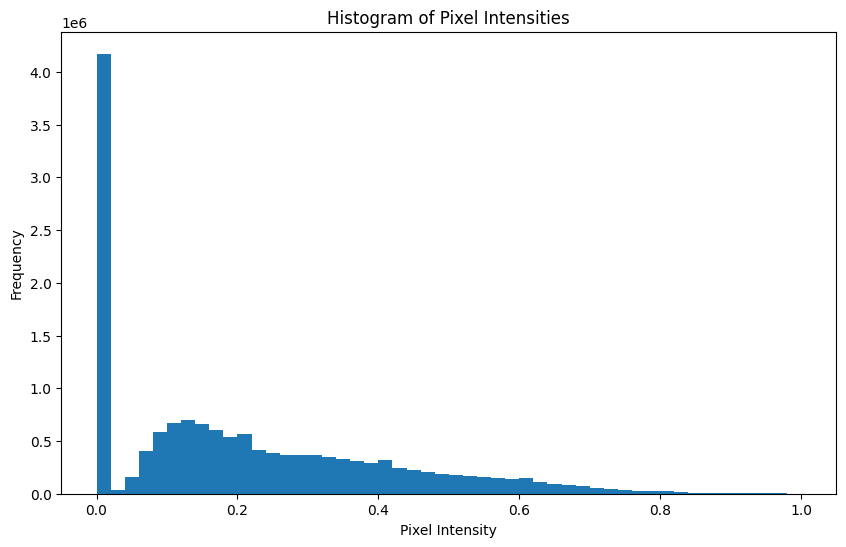

In [173]:
# Plot histogram of pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(batch_of_images.ravel(), bins=50, range=(0, 1))
plt.title("Histogram of Pixel Intensities")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show();

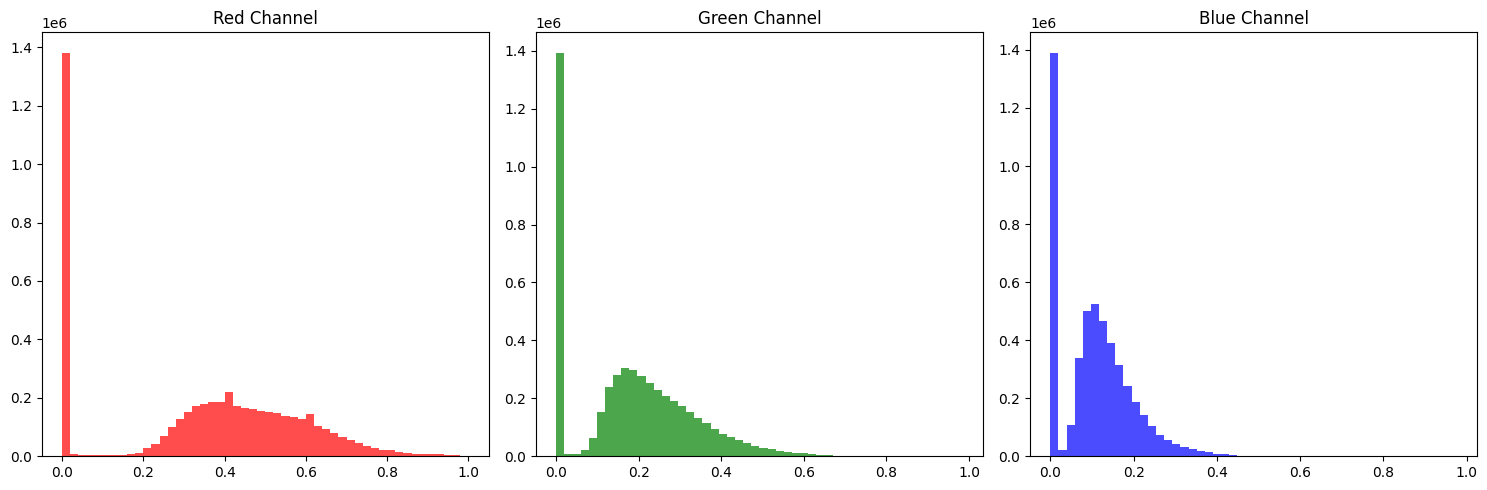

In [174]:
# Separate color channels
red_channel = batch_of_images[:, :, :, 0]
green_channel = batch_of_images[:, :, :, 1]
blue_channel = batch_of_images[:, :, :, 2]

# Plot histograms for each channel
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(red_channel.ravel(), bins=50, color='red', alpha=0.7)
plt.title("Red Channel")

plt.subplot(132)
plt.hist(green_channel.ravel(), bins=50, color='green', alpha=0.7)
plt.title("Green Channel")

plt.subplot(133)
plt.hist(blue_channel.ravel(), bins=50, color='blue', alpha=0.7)
plt.title("Blue Channel")

plt.tight_layout()
plt.show();

In [175]:
# Image channel correlations
r_g_corr = pearsonr(red_channel.ravel(), green_channel.ravel())[0]
r_b_corr = pearsonr(red_channel.ravel(), blue_channel.ravel())[0]
g_b_corr = pearsonr(green_channel.ravel(), blue_channel.ravel())[0]

print(f"Correlation between Red and Green channels: {r_g_corr:.4f}")
print(f"Correlation between Red and Blue channels: {r_b_corr:.4f}")
print(f"Correlation between Green and Blue channels: {g_b_corr:.4f}")

Correlation between Red and Green channels: 0.9373
Correlation between Red and Blue channels: 0.8791
Correlation between Green and Blue channels: 0.9503


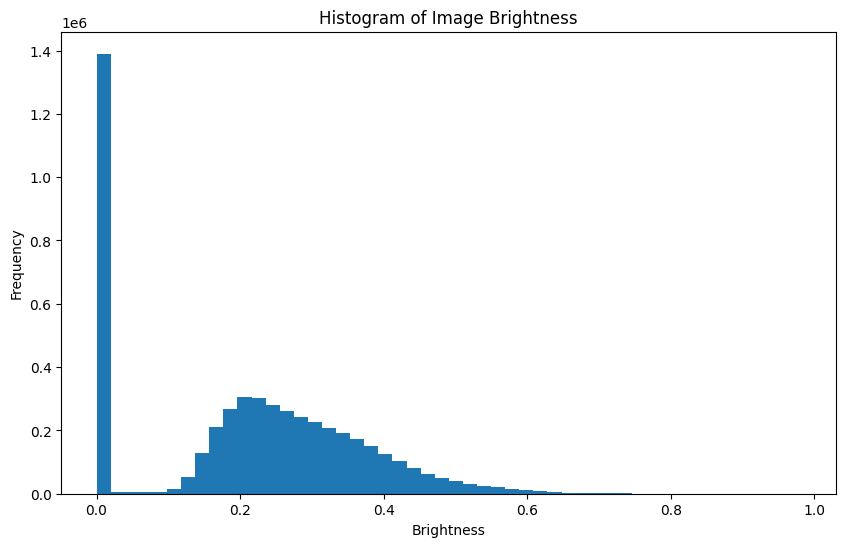

In [176]:
# Calculate brightness 
brightness = np.mean(batch_of_images, axis=3)

plt.figure(figsize=(10, 6))
plt.hist(brightness.ravel(), bins=50)
plt.title("Histogram of Image Brightness")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.show();

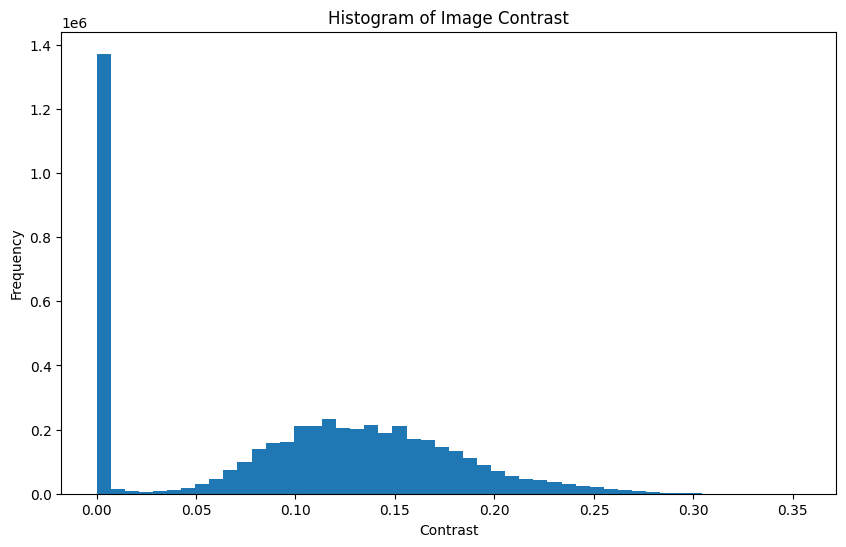

In [177]:
# Calculate contrast
contrast = np.std(batch_of_images, axis=3)

plt.figure(figsize=(10, 6))
plt.hist(contrast.ravel(), bins=50)
plt.title("Histogram of Image Contrast")
plt.xlabel("Contrast")
plt.ylabel("Frequency")
plt.show();

# Model Building 



## Data Pipeine

In [179]:
# Define the path to the fundus photos
IMAGE_PATH = '/Volumes/Extreme SSD/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos/'

# List of binary diagnosis columns
binary_diagnoses = ['diabetic_retinopathy', 'macular_edema', 'scar', 'nevus', 'amd',
                    'vascular_occlusion', 'hypertensive_retinopathy', 'drusens',
                    'hemorrhage', 'retinal_detachment', 'myopic_fundus', 'increased_cup_disc']

def parse_image(filename, labels):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match model input
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, labels

def augment_image(image, labels):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, labels

def create_dataset(labels_df, batch_size=32, shuffle=True, augment=False):
    # Create full file paths using the 'image_id' column
    filenames = labels_df['image_id'].apply(lambda x: os.path.join(IMAGE_PATH, x + '.jpg')).tolist()
    
    # Get labels
    labels = labels_df[binary_diagnoses].values.astype(np.float32).tolist()

    # Create tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    # Parse images and labels
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset


# Print information about the DataFrame
print("Columns in the DataFrame:")
print(labels.columns)
print("\nFirst few rows of the DataFrame:")
print(labels.head())
print("\nDataFrame info:")
labels.info()

# Split the data into train and validation sets
train_df, val_df = train_test_split(labels, test_size=0.2, random_state=12)

# Create datasets
train_dataset = create_dataset(train_df, batch_size=32, shuffle=True, augment=True)
val_dataset = create_dataset(val_df, batch_size=32, shuffle=False, augment=False)

# Print some information about the datasets
print(f"\nNumber of batches in training dataset: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Number of batches in validation dataset: {tf.data.experimental.cardinality(val_dataset)}")

# Inspect the first batch of the training dataset
for images, labels_batch in train_dataset.take(1):
    print(f"\nShape of the image batch: {images.shape}")
    print(f"Shape of the labels batch: {labels_batch.shape}")
    print(f"Sample labels from the first image: {labels_batch[0]}")

Columns in the DataFrame:
Index(['image_id', 'patient_id', 'camera', 'patient_age', 'patient_sex',
       'exam_eye', 'diabetes', 'nationality', 'optic_disc', 'vessels',
       'macula', 'DR_SDRG', 'DR_ICDR', 'focus', 'iluminaton', 'image_field',
       'artifacts', 'diabetic_retinopathy', 'macular_edema', 'scar', 'nevus',
       'amd', 'vascular_occlusion', 'hypertensive_retinopathy', 'drusens',
       'hemorrhage', 'retinal_detachment', 'myopic_fundus',
       'increased_cup_disc', 'other', 'quality'],
      dtype='object')

First few rows of the DataFrame:
   image_id  patient_id    camera  patient_age  patient_sex  exam_eye  \
0  img00001           1  Canon CR         48.0            1         1   
1  img00002           1  Canon CR         48.0            1         2   
2  img00003           2  Canon CR         18.0            2         1   
3  img00004           2  Canon CR         18.0            2         2   
4  img00005           3  Canon CR         22.0            1         1

2024-08-03 12:28:19.100210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Image classifier


In [180]:
# List of binary diagnosis columns
binary_diagnoses = ['diabetic_retinopathy', 'macular_edema', 'scar', 'nevus', 'amd',
                    'vascular_occlusion', 'hypertensive_retinopathy', 'drusens',
                    'hemorrhage', 'retinal_detachment', 'myopic_fundus', 'increased_cup_disc']

def create_medical_image_classifier(input_shape, num_diagnoses):
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_diagnoses, activation='sigmoid')(x)
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    
    # Freeze the base_model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

def train_classifier(model, train_dataset, val_dataset, epochs=10):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs
    )
    
    return model, history

# Custom metric to calculate the average AUC across all diagnoses
def average_auc(y_true, y_pred):
    auc_sum = 0
    num_labels = y_true.shape[1]
    for i in range(num_labels):
        auc_sum += tf.keras.metrics.AUC()(y_true[:, i], y_pred[:, i])
    return auc_sum / num_labels

# Usage example:
input_shape = (224, 224, 3)  # Adjust based on your image size
num_diagnoses = len(binary_diagnoses)

model = create_medical_image_classifier(input_shape, num_diagnoses)



trained_model, history = train_classifier(model, train_dataset, val_dataset)

# To save the model
trained_model.save('medical_image_classifier_multi_label.h5')

predictions = trained_model.predict(image_batch)


Epoch 1/10
121/357 ━━━━━━━━━━━━━━━━━━━━ 2:53 736ms/step - accuracy: 0.1656 - loss: 0.2054

KeyboardInterrupt: 

## StyleGAN Generator 

In [ ]:
class StylexGenerator(models.Model):
    def __init__(self, latent_dim, img_shape):
        super(StylexGenerator, self).__init__()
        self.img_shape = img_shape
        self.model = models.Sequential([
            layers.Dense(256, input_dim=latent_dim),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            layers.Dense(512),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            layers.Dense(1024),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            layers.Dense(tf.math.reduce_prod(img_shape), activation='tanh'),
            layers.Reshape(img_shape)
        ])

    def call(self, z):
        return self.model(z)

class StylexDiscriminator(models.Model):
    def __init__(self, img_shape):
        super(StylexDiscriminator, self).__init__()
        self.model = models.Sequential([
            layers.Flatten(input_shape=img_shape),
            layers.Dense(512),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(256),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(1, activation='sigmoid')
        ])

    def call(self, img):
        return self.model(img)

@tf.function
def train_step(real_images, labels, generator, discriminator, classifier, gen_optimizer, disc_optimizer):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Classifier guidance loss
        cls_outputs = classifier(generated_images, training=False)
        c_loss = classifier_loss(labels, cls_outputs)

        gen_total_loss = gen_loss + c_loss

    gradients_of_generator = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, c_loss

def generator_loss(fake_output):
    return tf.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def classifier_loss(labels, cls_outputs):
    return tf.losses.sparse_categorical_crossentropy(labels, cls_outputs)

# Usage example:
img_shape = (224, 224, 3)  # Adjust based on your image size
latent_dim = 100

generator = StylexGenerator(latent_dim, img_shape)
discriminator = StylexDiscriminator(img_shape)

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

# Load the classifier model
# classifier = ...
# dataset = ...

epochs = 100
for epoch in range(epochs):
    for image_batch, label_batch in dataset:
        gen_loss, disc_loss, c_loss = train_step(image_batch, label_batch, generator, discriminator, classifier, gen_optimizer, disc_optimizer)
    
    print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}, Classifier Loss: {c_loss:.4f}')

# Save the models
generator.save('stylex_generator.h5')
discriminator.save('stylex_discriminator.h5')

## Extract Features

In [ ]:
def extract_attributes(generator, classifier, num_samples, latent_dim, num_attributes):
    noise = tf.random.normal([num_samples, latent_dim])
    base_imgs = generator(noise)
    base_preds = classifier(base_imgs)
    
    attributes = []
    for i in range(latent_dim):
        noise_mod = noise.numpy()
        noise_mod[:, i] += 0.1  # Small perturbation
        mod_imgs = generator(noise_mod)
        mod_preds = classifier(mod_imgs)
        
        pred_diff = tf.reduce_mean(tf.abs(mod_preds - base_preds))
        attributes.append((i, pred_diff.numpy()))
    
    attributes.sort(key=lambda x: x[1], reverse=True)
    return [attr[0] for attr in attributes[:num_attributes]]

def visualize_attribute(generator, attribute_idx, latent_dim):
    noise = tf.random.normal([1, latent_dim])
    base_img = generator(noise)
    
    noise_mod = noise.numpy()
    noise_mod[0, attribute_idx] += 1  # Increase attribute
    mod_img = generator(noise_mod)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(base_img[0].numpy())
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mod_img[0].numpy())
    plt.title(f"Modified Image (Attribute {attribute_idx})")
    plt.axis('off')
    
    plt.show()


# generator = ...
# classifier = ...

latent_dim = 100
num_samples = 1000
num_attributes = 10

top_attributes = extract_attributes(generator, classifier, num_samples, latent_dim, num_attributes)

for attr in top_attributes:
    visualize_attribute(generator, attr, latent_dim)